In [1]:
import sys 
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn import preprocessing
from utils import utils
from utils import models

In [2]:
station = None
test_date = "2023/9/19"
# window_size = args.window_size
daily = 1
predictor = None
hidden_units = 32
learning_rate = 5e-3
if predictor == None:
    list_of_vars = ["temp_min", "temp_max", "temp_mean", "station"]
    list_of_vars_2 = ["temp_min", "temp_max", "temp_mean", "rainfall", "snow", "station"]
    list_of_vars_3 = ["temp_min", "temp_max", "temp_mean", "hist_temp_min", "hist_temp_max", "hist_temp_mean", "station"]
    list_of_vars_4 = ["temp_min", "temp_max", "temp_mean", "rainfall", "snow", "hist_temp_min", "hist_temp_max",
                        "hist_temp_mean", "hist_rainfall", "hist_snow", "station"]
else:
    list_of_vars =  [predictor, "station"]
    list_of_vars_2 = [predictor, "station"]
    list_of_vars_3 =  [predictor, "station"]
    list_of_vars_4 = [predictor, "station"]
names_models = {0 : ["temp_min", "temp_min_hist"], 1 : ["temp_max", "temp_max_hist"], 2 : ["temp_mean", "temp_mean_hist"], 
                3 : ["rainfall", "rainfall_hist"], 4 : ["snow", "snow_hist"]}
loss_functions = {0 : torch.nn.MSELoss(), 1 : torch.nn.MSELoss(), 2 : torch.nn.MSELoss(),
    3 : models.SpecialCrossEntropyLoss(), 4 : models.SpecialCrossEntropyLoss()}
predictors_list = { 0 : [list_of_vars, list_of_vars_3], 1 : [list_of_vars, list_of_vars_3], 2 : [list_of_vars, list_of_vars_3],
    3 : [list_of_vars_2, list_of_vars_4], 4 : [list_of_vars_2, list_of_vars_4]}
test_processes = {0 : models.test_model, 1 : models.test_model, 2 : models.test_model,
    3 : models.test_model_classifier, 4 : models.test_model_classifier}
model_path = "../models/lstm/"

# Load data
print("Loading data...")
data = utils.load_data(daily, station)
train_data_pd, test_data_pd = models.train_test_split(data, test_date, daily)

# Load historical data
print("Loading historical data...")
historical_data = utils.load_data_with_historical(daily, station)
train_data_hist_pd, test_data_hist_pd = models.train_test_split(historical_data, test_date, daily)

Loading data...
Loading historical data...


Window size plots

In [50]:
window_sizes = [7, 14, 21]
test_accs = {7: [], 14: [], 21: []}
for window_size in window_sizes:
    for i in range(3):
        train_data= models.WindowDataset(train_data_pd[predictors_list[i][0]], window_size, 4, i)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

        test_data = models.WindowDataset(test_data_pd[predictors_list[i][0]], window_size, 4, i)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
        x, y = next(iter(train_loader))

        # Create model
        inputsize = x.shape[2]
        model = models.LSTM(input_size=inputsize, hidden_size=hidden_units, output_size=4, num_layers=1, dropout=0.0)
        loss_function = loss_functions[i]
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Train model
        print("Using window size {}, Training model {}...".format(window_size, names_models[i][0]))
        models.train_loop(model, train_loader,  optimizer, loss_function, epochs=20)

        # Test model
        test_loss = test_processes[i](model, test_loader, loss_function)
        print("Using window size {}, TEST LOSS for model {} : {}".format(window_size, names_models[i][0], test_loss))
        test_accs[window_size].append(test_loss)
print("Done training and testing models")

Using window size 7, Training model temp_min...
Epoch: 0, Loss: 77.2162501339985
Epoch: 10, Loss: 14.95325940514579
Using window size 7, TEST LOSS for model temp_min : 3.7464937909823757
Using window size 7, Training model temp_max...
Epoch: 0, Loss: 175.5489679617325
Epoch: 10, Loss: 18.22970817294823
Using window size 7, TEST LOSS for model temp_max : 4.378316992819342
Using window size 7, Training model temp_mean...
Epoch: 0, Loss: 106.65907720381838
Epoch: 10, Loss: 14.461049380036174
Using window size 7, TEST LOSS for model temp_mean : 3.379084525575053
Using window size 14, Training model temp_min...
Epoch: 0, Loss: 66.11404781535192
Epoch: 10, Loss: 15.136192384710167
Using window size 14, TEST LOSS for model temp_min : 3.8423846427112407
Using window size 14, Training model temp_max...
Epoch: 0, Loss: 177.3319749202825
Epoch: 10, Loss: 18.623246042861552
Using window size 14, TEST LOSS for model temp_max : 4.428849847811937
Using window size 14, Training model temp_mean...
Epoc

In [55]:
df = pd.DataFrame(test_accs).set_index([pd.Index(["temp_min", "temp_max", "temp_mean"])])
df = df.round(3)

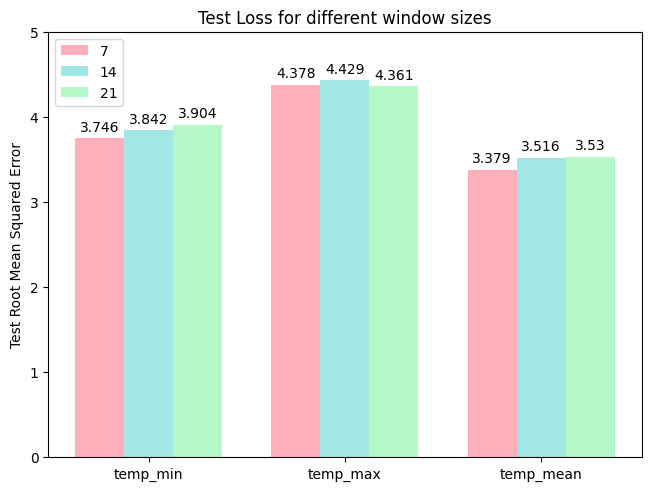

In [58]:
x = np.arange(len(df.columns))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
colors = ['#FFAEBC', '#A0E7E5', '#B4F8C8']

for y in df:
    offset = width * multiplier
    rects = ax.bar(x + offset, df[y], width, label=y, color=colors[multiplier])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Test Root Mean Squared Error')
ax.set_title('Test Loss for different window sizes')
ax.set_xticks(x + width, df.index)
ax.legend(loc='upper left')
ax.set_ylim(0, 5)

plt.show()

In [42]:
for x in df:
    print(x)
    print(df[x])
    # print(df[x])

7
temp_min     3.784930
temp_max     4.278943
temp_mean    3.455606
Name: 7, dtype: float64
10
temp_min     3.782300
temp_max     4.409597
temp_mean    3.404966
Name: 10, dtype: float64
14
temp_min     3.821388
temp_max     4.334453
temp_mean    3.365763
Name: 14, dtype: float64
